In [ ]:
from math import ceil
import pysal as ps
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler, MinMaxScaler

rbs = RobustScaler(quantile_range=[0.025,0.975])
mms = MinMaxScaler(feature_range=(0,1))
pts = PowerTransformer()
scaler = StandardScaler()

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from esda.adbscan import ADBSCAN
from sklearn.decomposition import PCA

In [21]:
from geopandas import GeoDataFrame

In [22]:
url = 'MetroRail.geojson'
gdf = gpd.read_file(url)

gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   NPTREF    190 non-null    object  
 1   RSTNAM    190 non-null    object  
 2   geometry  190 non-null    geometry
dtypes: geometry(1), object(2)
memory usage: 4.6+ KB


In [ ]:
df = pd.read_csv('train_forcluster.csv',
                 na_values=[':'], low_memory=False)
df.info()

In [24]:
ppd = pd.merge(df, gdf, left_on='geoid', right_on='NPTREF', how='inner').reset_index()
ppd.shape
ppd.head(5)

,index,geoid,betweeness,closeness,eigenvector,freq,line,bus_route,car_park,near_highway,...,sum_lab,poi_count,entropy,Lane,bike_capacity,intersection,ave_gmal,NPTREF,RSTNAM,geometry
0,0,9400ZZMAABM,1344.000000,0.000732,0.084502,20.000,2,34,2,0.029578,...,3591,20,1.250721,3.557799,0,6,11.776998,9400ZZMAABM,Abraham Moss,POINT (-2.23542 53.51051)
1,1,9400ZZMAALT,175.000000,0.000554,0.000998,160.000,2,25,45,0.053735,...,3258,138,0.416671,1.007778,58,36,19.188176,9400ZZMAALT,Altrincham,POINT (-2.34728 53.38745)
2,2,9400ZZMAANC,125.833333,0.000565,0.002794,5.000,2,35,0,0.006399,...,4490,225,0.838144,2.980509,16,256,11.258944,9400ZZMAANC,Anchorage,POINT (-2.28602 53.47431)
3,3,9100ARDWICK,927.166667,0.000747,0.050622,1.875,2,25,0,0.038448,...,472,21,2.157234,3.462621,0,6,17.415557,9100ARDWICK,ARDWICK,POINT (-2.21337 53.47121)
4,4,9100ASHBRYS,885.666667,0.000684,0.017106,105.000,3,27,0,0.057072,...,980,13,-1.748754,2.330456,0,32,14.908093,9100ASHBRYS,ASHBURYS,POINT (-2.19475 53.47187)


In [25]:
ppd = GeoDataFrame(ppd)

In [26]:
def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k,v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)

tfont = {'fontname':'Liberation Sans Narrow', 'horizontalalignment':'left'}

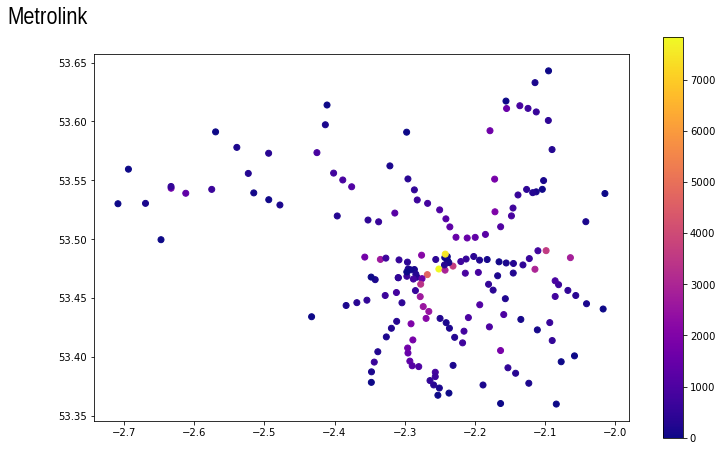

In [27]:
f = plt.figure()
f.set_size_inches(12,7)

ax1 = f.add_subplot()
ppd.plot(column='betweeness', legend=True, cmap='plasma', figsize=(12,6), ax=ax1)

f.subplots_adjust(top=0.92)
f.suptitle(f"Metrolink", x=0.025, size=24, **tfont);

In [9]:
to_cluster = ppd[['geoid','betweeness','freq','line','bus_route','car_park','near_highway','sum_pop','sum_lab','poi_count',
                 'entropy','Lane','bike_capacity','intersection','ave_gmal']].set_index('geoid').copy()
to_cluster.head()

,betweeness,freq,line,bus_route,car_park,near_highway,sum_pop,sum_lab,poi_count,entropy,Lane,bike_capacity,intersection,ave_gmal
geoid,,,,,,,,,,,,,,
9400ZZMAABM,1344.000000,20.000,2,34,2,0.029578,12574,3591,20,1.250721,3.557799,0,6,11.776998
9400ZZMAALT,175.000000,160.000,2,25,45,0.053735,6081,3258,138,0.416671,1.007778,58,36,19.188176
9400ZZMAANC,125.833333,5.000,2,35,0,0.006399,7801,4490,225,0.838144,2.980509,16,256,11.258944
9100ARDWICK,927.166667,1.875,2,25,0,0.038448,1648,472,21,2.157234,3.462621,0,6,17.415557
9100ASHBRYS,885.666667,105.000,3,27,0,0.057072,3239,980,13,-1.748754,2.330456,0,32,14.908093


In [10]:
to_cluster.describe()

,betweeness,freq,line,bus_route,car_park,near_highway,sum_pop,sum_lab,poi_count,entropy,Lane,bike_capacity,intersection,ave_gmal
count,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000
mean,807.774011,43.359463,2.169492,30.468927,42.259887,0.023463,5707.118644,2603.711864,77.875706,1.219487,3.597380,97.237288,33.282486,15.576501
std,1098.073053,52.791207,0.956186,17.451895,112.028153,0.015797,3298.246291,1608.507157,178.525228,2.306460,2.365756,313.922164,53.787771,17.557610
min,0.000000,1.875000,1.000000,1.000000,0.000000,0.001885,0.000000,0.000000,1.000000,-6.495189,0.000000,0.000000,0.000000,1.682645
25%,175.000000,10.000000,2.000000,21.000000,0.000000,0.012501,3364.000000,1340.000000,10.000000,0.677120,1.811969,0.000000,4.000000,8.346675
50%,519.000000,25.000000,2.000000,28.000000,0.000000,0.019238,5754.000000,2536.000000,20.000000,1.089299,3.150600,16.000000,13.000000,10.644889
75%,954.333333,60.000000,2.000000,36.000000,32.000000,0.030678,7483.000000,3480.000000,50.000000,1.274947,5.111205,50.000000,38.000000,14.889589
max,7829.250000,310.000000,9.000000,110.000000,1000.000000,0.084481,17688.000000,8561.000000,1107.000000,22.401314,9.914807,2644.000000,334.000000,108.467996


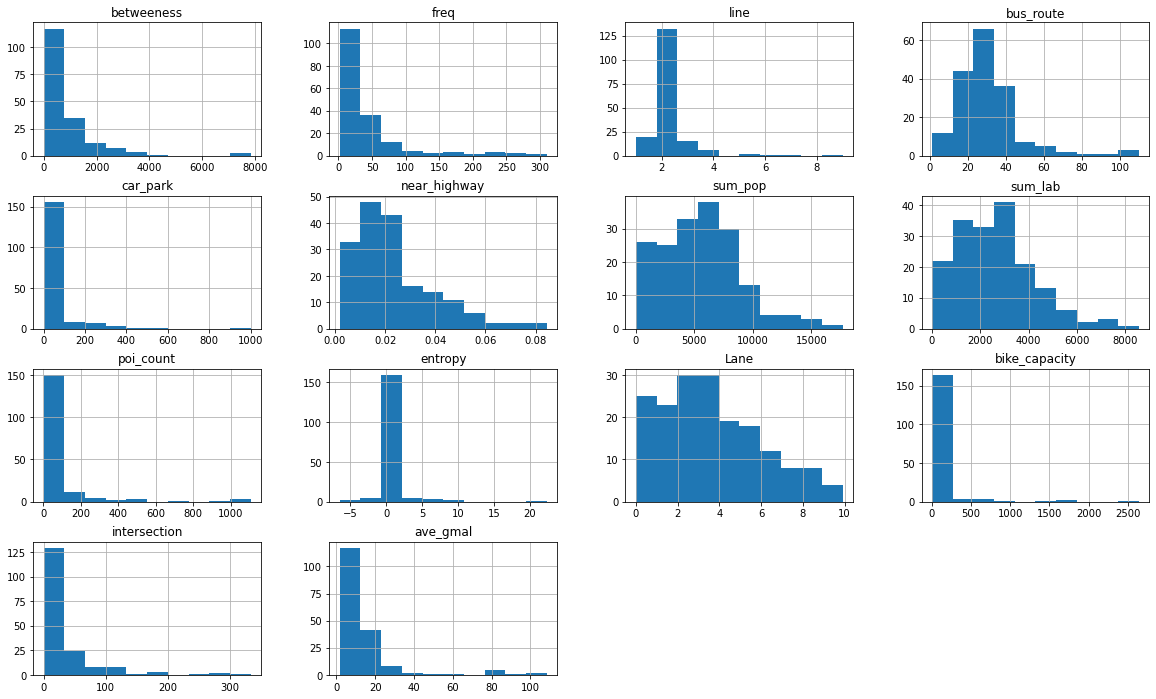

In [28]:
df_analyse_histograms = to_cluster.hist(figsize = (20,12))

In [29]:
normed = to_cluster.copy()
for c in to_cluster.columns.values:
    normed[c] = pts.fit_transform(to_cluster[c].values.reshape(-1,1))
normed.sample(5)

,betweeness,freq,line,bus_route,car_park,near_highway,sum_pop,sum_lab,poi_count,entropy,Lane,bike_capacity,intersection,ave_gmal
geoid,,,,,,,,,,,,,,
9400ZZMACEM,-0.565957,-0.918042,-0.004382,0.666299,-0.809067,0.405049,0.345964,0.360111,-0.273183,0.013782,-0.314968,0.877961,-0.561833,0.148462
9400ZZMAECS,-0.075162,-0.918042,-0.004382,0.215769,-0.809067,1.610769,-0.892045,-0.855407,0.650060,0.034112,1.615457,0.447590,0.364767,0.311438
9400ZZMASTP,-0.253054,0.015432,1.897850,3.044603,-0.809067,-0.831831,0.532352,0.694992,2.218181,-0.110133,1.323291,1.997061,1.450142,2.459512
9100WIGANNW,1.029247,1.708852,1.167671,1.278088,1.556324,1.537727,-1.213916,-0.946290,1.151351,-0.592584,1.157381,0.090245,1.069580,1.478529
9400ZZMAPLL,-0.536136,-0.918042,-0.004382,0.154027,-0.809067,0.137182,-0.256409,-0.191073,-0.451684,0.215217,-0.100203,0.935176,0.194610,-0.144354


In [30]:
normed.to_csv(r'normedtrain.csv', index = True)

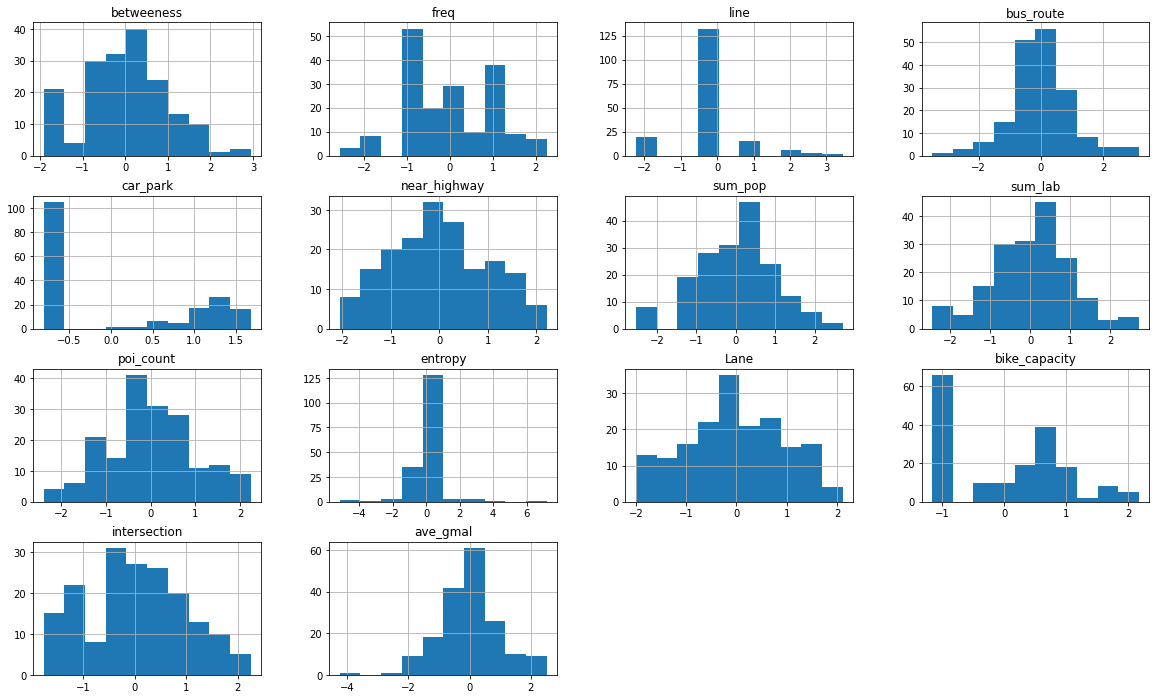

In [31]:
df_analyse_histograms = normed.hist(figsize = (20,12))

In [32]:
rand_st_int = 10 
pca = PCA(random_state=rand_st_int)

normed_pca = pca.fit_transform(normed)
print('Explained variance ratio of each component:')
print(pca.explained_variance_ratio_)

Explained variance ratio of each component:
[0.31265207 0.14544675 0.11449243 0.10554982 0.07060619 0.06726964
 0.04462397 0.03615762 0.03067075 0.02750244 0.01916566 0.01308897
 0.00999594 0.00277774]


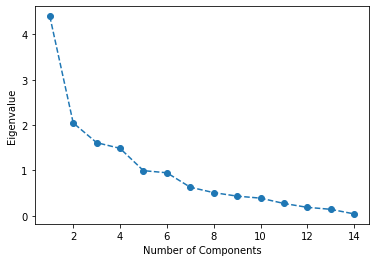

In [33]:
dfpc = pd.DataFrame({'eigenvalue':pca.explained_variance_,
             'PC':list(range(1, pca.n_components_ + 1))})

plt.plot(dfpc['PC'], dfpc['eigenvalue'], marker='o', linestyle = '--')
plt.xlabel('Number of Components')
plt.ylabel('Eigenvalue')
plt.show()

In [54]:
pca = PCA(n_components = 3)

normed_pca = pca.fit_transform(normed)
print('Explained variance ratio of each component:')
print(pca.explained_variance_ratio_)

Explained variance ratio of each component:
[0.31265207 0.14544675 0.11449243]


In [55]:
list_var = normed.columns.tolist()
print(list_var)

['betweeness', 'freq', 'line', 'bus_route', 'car_park', 'near_highway', 'sum_pop', 'sum_lab', 'poi_count', 'entropy', 'Lane', 'bike_capacity', 'intersection', 'ave_gmal']


In [36]:
df_PrincipleComp = pd.DataFrame(pca.components_, columns = list_var)
df_PrincipleComp

,betweeness,freq,line,bus_route,car_park,near_highway,sum_pop,sum_lab,poi_count,entropy,Lane,bike_capacity,intersection,ave_gmal
0,-0.233065,-0.003274,-0.300524,-0.375974,0.141832,0.101085,-0.218526,-0.232802,-0.322480,0.028768,-0.308555,-0.295914,-0.345875,-0.417722
1,-0.227986,-0.258828,-0.152307,0.020695,-0.086798,0.047623,-0.556788,-0.527646,0.163697,-0.014425,0.336927,0.063685,0.324063,0.097893
2,0.351626,0.490629,0.410902,-0.138406,0.410418,-0.022757,-0.253255,-0.263284,-0.058940,-0.354809,0.098524,-0.069833,0.005226,0.035421


In [56]:
score_pca = pca.transform(normed)
score_pca

array([[-3.87961588e-01, -1.61665344e+00, -3.77017597e-01],
       [-5.42962003e-01, -5.82177756e-01,  8.56844466e-01],
       [-1.95195716e+00,  5.30421560e-01, -1.94343277e+00],
       [ 7.47718188e-01,  2.02874906e+00, -7.43072170e-01],
       [ 9.06575537e-02,  3.69573603e-01,  2.03160079e+00],
       [ 1.12494075e+00,  1.56768191e+00,  1.31122793e+00],
       [-6.87103541e-02,  9.84539543e-01,  7.93971428e-01],
       [-2.39742315e+00,  5.34893644e-02,  1.71338979e+00],
       [ 1.90291511e+00, -1.27957526e+00,  6.69504545e-01],
       [-5.55269471e-02,  5.65584947e-01, -5.31496119e-01],
       [-2.62266286e-01,  7.25752254e-01, -3.30812380e-01],
       [-1.33112673e+00, -5.19921928e-02, -5.73936111e-01],
       [ 2.95352292e-01,  3.98936115e+00,  5.22847543e-01],
       [ 9.61447322e-02, -7.70786713e-01, -5.38182201e-01],
       [-1.22677904e+00, -1.51921411e+00, -1.25736090e+00],
       [-4.33699209e-02, -1.23012179e+00, -2.24476825e-01],
       [ 4.83059983e+00, -6.32334681e-01

In [38]:
print('Eigenvalues of each component:')
print(pca.explained_variance_)

Eigenvalues of each component:
[4.40199909 2.04782408 1.61200143]


In [11]:
score_pca = pd.read_csv('npm.csv',
                 na_values=[':'], low_memory=False)
score_pca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   geoid   177 non-null    object 
 1   node    177 non-null    float64
 2   place   177 non-null    float64
 3   design  177 non-null    float64
dtypes: float64(3), object(1)
memory usage: 5.7+ KB


In [12]:
score_pca = score_pca.set_index('geoid').copy()
score_pca.head()

,node,place,design
geoid,,,
9400ZZMAABM,0.189202,0.616145,-0.335439
9400ZZMAALT,0.891060,0.419056,0.309596
9400ZZMAANC,-0.683345,0.799664,0.578230
9100ARDWICK,-0.486125,-0.571258,-0.192328
9100ASHBRYS,0.687753,-0.899918,-0.111137


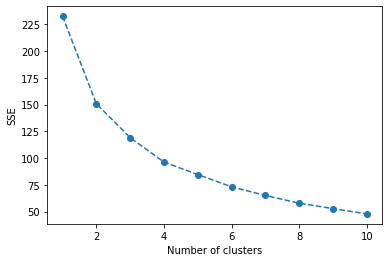

In [13]:
# calculate SSE for a range of number of cluster
list_SSE = []
min_k = 1
max_k = 10
range_k = range(min_k, max_k+1)
for i in range_k:
    km = KMeans(
        n_clusters=i, init='k-means++', random_state=0)
    km.fit(score_pca)
    # inertia is a concept in physics. Roughly it means SSE of clustering.
    list_SSE.append(km.inertia_)

# plot
plt.plot(range_k, list_SSE, marker='o', linestyle = '--')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [14]:
k_cluster = 4
random_seed = 3
kmeans_method = KMeans(n_clusters=k_cluster,random_state=random_seed)
kmeans_method.fit(score_pca)

KMeans(n_clusters=4, random_state=3)

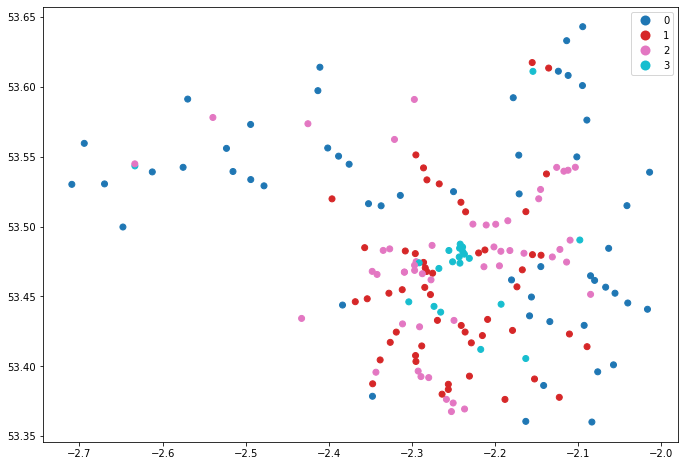

In [15]:
ppd['Kmeans_Cluster'] = kmeans_method.labels_
ppd.plot(column='Kmeans_Cluster', categorical=True, legend=True, figsize=(12,8));

In [60]:
ppd_kpca = pd.concat([ppd.reset_index(drop = True), pd.DataFrame(score_pca)],axis = 1)
ppd_kpca.columns.values[-3: ] = ['Component1','Component2','Component3']

In [61]:
ppd_kpca['Segement'] = ppd_kpca['Kmeans_Cluster'].map({0:'First',1:'Second',2:'Third',3:'fourth',4:"fifth"})

In [16]:
score_pca['Kmeans_Cluster'] = kmeans_method.labels_
score_pca['Segement'] = score_pca['Kmeans_Cluster'].map({0:'First',1:'Second',2:'Third',3:'Fourth'})

/opt/conda/envs/sds2020/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


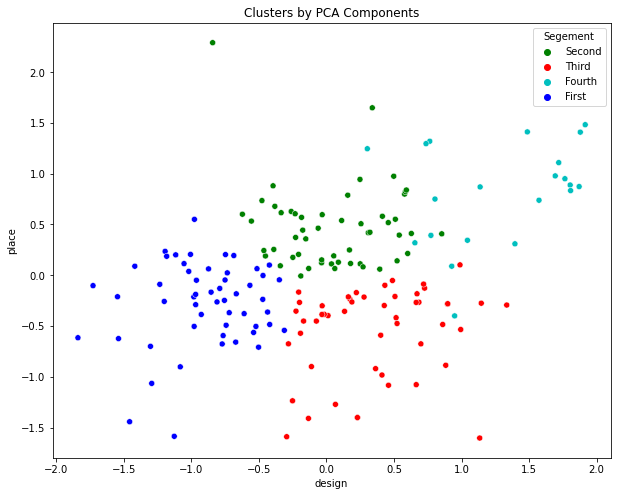

In [18]:
x_axis = score_pca['design']
y_axis = score_pca['place']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis,y_axis,hue = score_pca['Segement'], palette = ['g','r','c','b'])
plt.title('Clusters by PCA Components')
plt.show()

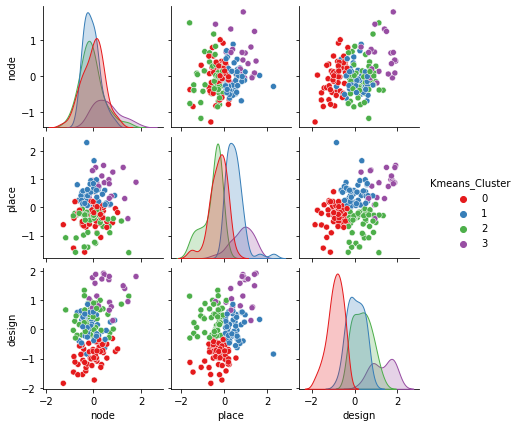

In [19]:
plot_norm = sns.pairplot(score_pca,hue = 'Kmeans_Cluster',height = 2,palette = 'Set1')